# Capstone: Detecting Aircraft in Satellite Imagery
## Part 1 - EDA
---

## Background
The aim of this project is to help address the difficult task of detecting the location of airplanes in satellite images. Automating this process can be applied to many issues including monitoring airports for activity and traffic patterns, and defense intelligence. Tapping on the increasing quality of satellite imagery, military threats can be detected from afar, and automated systems reduce the amount of manpower required for constant surveillance of satellite captured images. The quantity and quality of detections from a single system can supplement the work of many professionals.

Further, while there exists global and near-global , these technologies require aircraft to be equipped with the appropriate transponders. 
Flying over oceanic airspace, there are only a few available:
- Ground-based ADS-B
- Satellite-based ADS-B
- ADS-C


Most of these already tap on the existing satellite networks available (e.g. GNSS, GALILEO, BEIDOU), so this would be an extension of such capabilities. Further, there is no requirement to install any new equipment on board.  
Airport usage and capacity can also be monitored, albeit on a less real-time basis

## Problem Statement
Civil aviation authorities and airport operators need a way to improve air traffic management, safety and capacity monitoring capabilities. Similarly, space management of aircraft storage sites like the one in Alice Springs (where SIA and Scoot parked their aircraft during the COVID-19 pandemic) can be a challenge as well.

## The Project
Build a computer vision model that can accurately identify and locate aircraft within satellite images, achieving at least 0.75 mAP.

## Target Metric
### Mean Average Precision (mAP)
A metric used to evaluate object detection models. mAP formula is based on the following sub metrics:
- Confusion Matrix,
- Intersection over Union(IoU),
- Recall, 
- Precision

The mAP incorporates the trade-off between precision and recall and considers both false positives (FP) and false negatives (FN). An aircraft detection system would need to balance recall with precision to ensure that capacity is correctly monitored. The presence of too many false detections (whether positive or negative) would be highly detrimental to efficiency and the effectiveness of the model.

---

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import random
import ast

# plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont

In [2]:
# set random seeds for reproducibility
random.seed(8888)
np.random.seed(8888)

## Dataset - Airbus Aircrafts Dataset Sample
Official summary: Aircrafts are usually seen on airports. Earth observation satellites like Airbus' Pleiades twin satellites acquire pictures of airports all over the world on a regular basis. Deep Learning can be used to detect automatically the number, size and type of aircrafts present on the site. In turn, this can provide information about the activity of any airport.
- source: https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset

The images folder contains 103 extract of Pleiades imagery at roughly 50 cm resolution. Each each image is stored as a JPEG file of size 2560 x 2560 pixels (i.e. 1280 meters on ground). The locations are various airports worldwide. Some airports appear multiple times at different acquisition dates. Some images also include fog or cloud for diversity.

This dataset is a demonstration version of larger and more advanced deep learning datasets created from Airbus satellite imagery. It is provided for demonstration purpose only.

## Visualizing the Dataset

## Images

In [3]:
IMAGES_DIR = os.path.join('data','images')

In [4]:
imgs = [os.path.join(IMAGES_DIR, x) for x in os.listdir(IMAGES_DIR) if x[-3:] == "jpg"]

Channels: 3


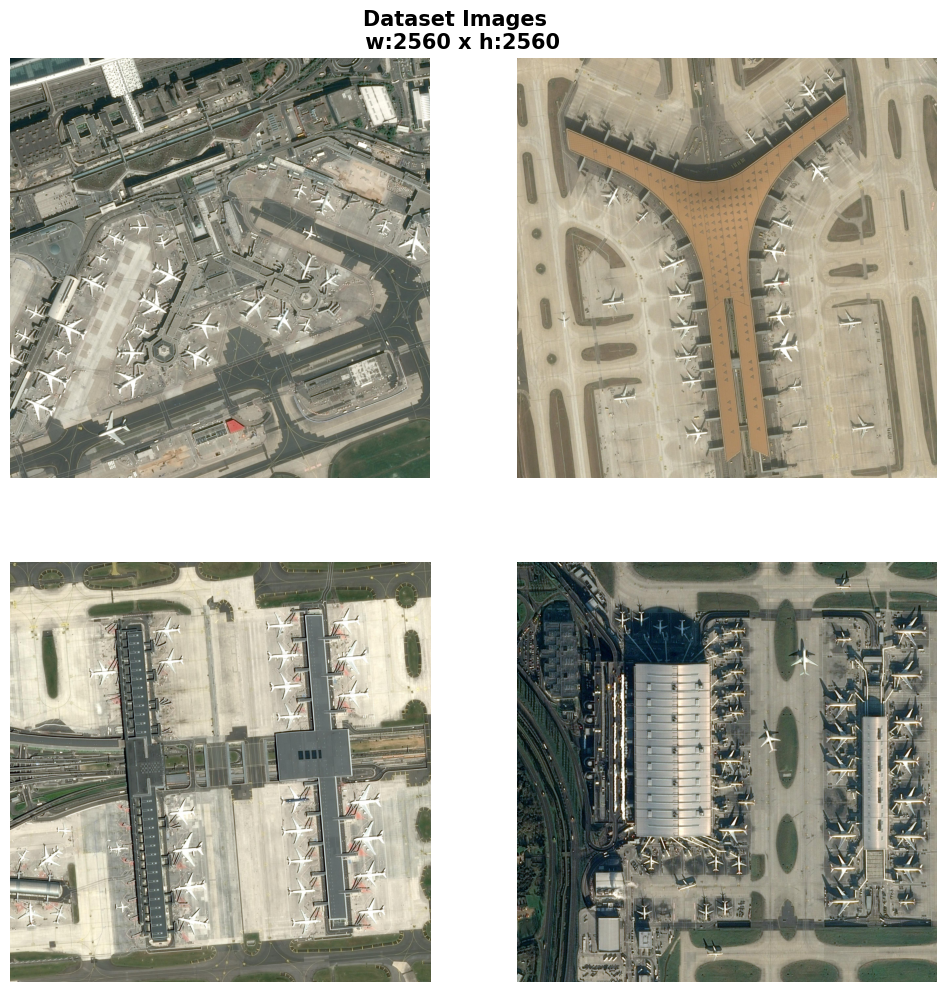

In [5]:
# get random image file 
sample_path = random.sample(imgs, 4)

plt.figure(figsize=(12,12))

for i in range(4):
    plt.subplot(2,2,(i+1))
    image = Image.open(sample_path[i])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle(f'Dataset Images \n w:{image.size[0]} x h:{image.size[1]}',fontsize=15, fontweight='bold', y=0.92)
print(f'Channels: {len(image.mode)}')

Dataset contains satellite imagery of different airports, showing aircraft, parking bays, taxiways and runways. Aircraft are present across different sorts of "terrain".
Images are 2560x2560 with 3 channels.

## What do the provided annotations look like?

In [6]:
# load the dataset
labels = pd.read_csv('data/annotations.csv', 
                converters={'geometry': lambda x: ast.literal_eval(x.rstrip('\r\n'))})
labels.head()

id                                  image_id  \
0   1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
1   2  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
2   3  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
3   4  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
4   5  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   

                                            geometry     class  
0  [(135, 522), (245, 522), (245, 600), (135, 600...  Airplane  
1  [(1025, 284), (1125, 284), (1125, 384), (1025,...  Airplane  
2  [(1058, 1503), (1130, 1503), (1130, 1568), (10...  Airplane  
3  [(813, 1518), (885, 1518), (885, 1604), (813, ...  Airplane  
4  [(594, 938), (657, 938), (657, 1012), (594, 10...  Airplane

In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3425 non-null   int64 
 1   image_id  3425 non-null   object
 2   geometry  3425 non-null   object
 3   class     3425 non-null   object
dtypes: int64(1), object(3)
memory usage: 107.2+ KB


In [8]:
labels.isnull().sum()

id          0
image_id    0
geometry    0
class       0
dtype: int64

Annotation dataset contains 3425 rows, each containing the bounding box geometry for a single aircraft detection, whether it is truncated or not, and the corresponding image_id to which it belongs. Dataset is clean, with no missing values.

In [9]:
labels['geometry'][1]

[(1025, 284), (1125, 284), (1125, 384), (1025, 384), (1025, 284)]

bounding box coordinates are given as the four corners of each rectangle. the xmin, ymin, xmax, ymax values will be extracted accordingly. (Pascal VOC annotation format)

In [10]:
def get_bbox_coords(geometry):
    arr = np.array(geometry).T # transpose the array to obtain x values on one side and y values on the other
    xmin = np.min(arr[0])
    ymin = np.min(arr[1])
    xmax = np.max(arr[0])
    ymax = np.max(arr[1])
    return (xmin, ymin, xmax, ymax)

# Create bounds, width and height
labels.loc[:,'bbox'] = labels.loc[:,'geometry'].apply(get_bbox_coords)

# Display head
labels.head()

id                                  image_id  \
0   1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
1   2  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
2   3  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
3   4  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
4   5  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   

                                            geometry     class  \
0  [(135, 522), (245, 522), (245, 600), (135, 600...  Airplane   
1  [(1025, 284), (1125, 284), (1125, 384), (1025,...  Airplane   
2  [(1058, 1503), (1130, 1503), (1130, 1568), (10...  Airplane   
3  [(813, 1518), (885, 1518), (885, 1604), (813, ...  Airplane   
4  [(594, 938), (657, 938), (657, 1012), (594, 10...  Airplane   

                       bbox  
0      (135, 522, 245, 600)  
1    (1025, 284, 1125, 384)  
2  (1058, 1503, 1130, 1568)  
3    (813, 1518, 885, 1604)  
4     (594, 938, 657, 1012)

In [11]:
print(labels['class'].value_counts())

Airplane              3316
Truncated_airplane     109
Name: class, dtype: int64


Aicraft annotations are split into 2 types, full airplane and truncated airplane. Let us next take a look at what an image looks like with the annotated bounding boxes and labels draw in.

## Plot sample image containing truncated airplane with annotations

In [12]:
# function to plot image with annotations
def plot_annot(df, img_id):
    img_path = os.path.join('data','images',img_id)
    image = Image.open(img_path)

    font_path = "C:\Windows\Fonts\Arial.ttf" # None bitmap font so that the font size can be controlled.
    font = ImageFont.truetype(font_path, size=20)

    plotted_image = ImageDraw.Draw(image)

    counter = 0
    for row in df[df['image_id'] == img_id].itertuples():
        counter += 1
        plotted_image.rectangle(row.bbox, width=3, outline=(0,0,255))
        plotted_image.text((row.bbox[0], row.bbox[1]), df.loc[row.Index,'class'], font=font, fill=(0,0,255))

    counter_font = ImageFont.truetype(font_path, size=70)
    plotted_image.text((0,0), f'Number of Aircraft: {counter}', font=counter_font, fill=(0,0,255))

    plt.figure(figsize=(8,8), frameon=False)
    plt.axis('off')
    plt.imshow(image)

In [13]:
# randomly pick image with truncated aircraft
row = random.choice(labels[labels['class'] == 'Truncated_airplane'].index.values)
img_id = labels.loc[row,'image_id']

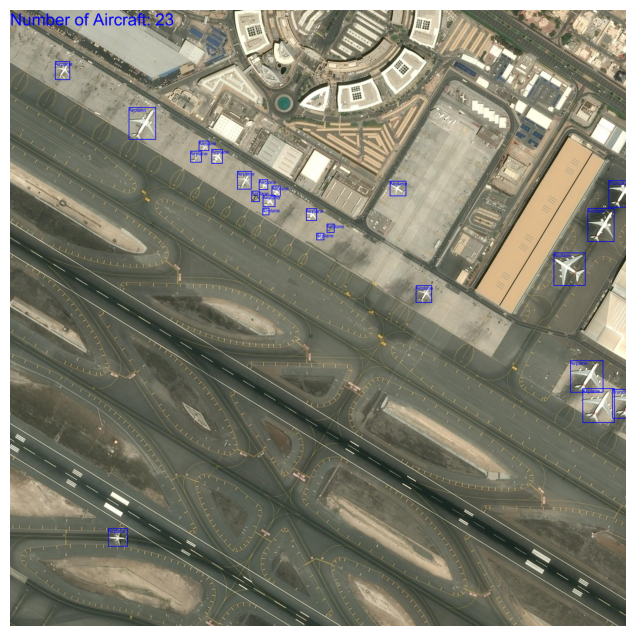

In [14]:
plot_annot(labels, img_id)

The above image is a sample with annotations drawn in. At the right hand side of the image are 2 instances of a truncated aircraft. The annotations are generally tight and appropriately labelled. There are 21 aircraft and 2 truncated aircraft present, totalling 23.

## Include Width and Height into Dataframe
The YOLO format requires the width and height of bounding boxes, these will as such be tabulated here using the dataframe for easier processing down the line.

In [15]:
final_df = labels.drop(['geometry','id'], axis=1)

In [16]:
def width(bbox):
    (xmin, ymin, xmax, ymax) = bbox
    return abs(xmax - xmin)

def height(bounds):
    (xmin, ymin, xmax, ymax) = bounds
    return abs(ymax - ymin)

In [17]:
final_df.loc[:,'width'] = final_df.loc[:,'bbox'].apply(width)
final_df.loc[:,'height'] = final_df.loc[:,'bbox'].apply(height)

In [18]:
final_df.head()

image_id     class  \
0  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg  Airplane   
1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg  Airplane   
2  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg  Airplane   
3  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg  Airplane   
4  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg  Airplane   

                       bbox  width  height  
0      (135, 522, 245, 600)    110      78  
1    (1025, 284, 1125, 384)    100     100  
2  (1058, 1503, 1130, 1568)     72      65  
3    (813, 1518, 885, 1604)     72      86  
4     (594, 938, 657, 1012)     63      74

---
## Exploratory Data Analysis
Here we look at some numbers and distributions regarding the dataset to look for anomalies.

In [19]:
unique, counts = np.unique(final_df['image_id'], return_counts=True)
#per_image = np.asarray((unique, counts)).T
print(f'Fewest aircraft in an image: {min(counts)}')
print(f'Most aircraft in an image: {max(counts)}')
print(f'Mean number of aircrafts per image: {int(np.mean(counts))}')
print(f'Total number of aircraft: {sum(counts)}')
print(f'Number of images: {len(imgs)}')

Fewest aircraft in an image: 5
Most aircraft in an image: 92
Mean number of aircrafts per image: 33
Total number of aircraft: 3425
Number of images: 103


### Distribution of Aircraft Counts Per Image

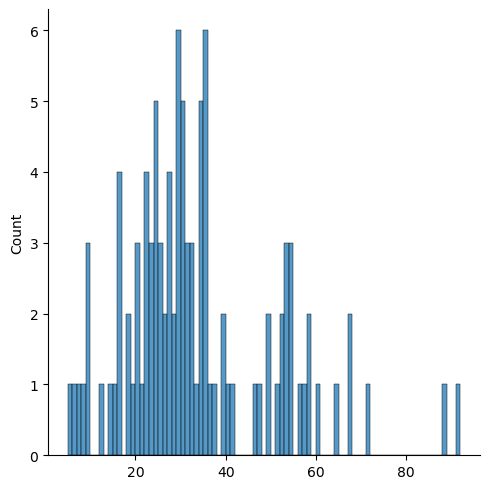

In [20]:
sns.displot(counts, binwidth=1)

Bulk of the images have betwen 10-40 aircraft. There are however, 2 images which stand out. We will next investigate the 2 images on the extreme right with >80 aircraft

In [21]:
ac_num = final_df.groupby('image_id').count()
ac_num[ac_num['bbox']>80]

class  bbox  width  height
image_id                                                            
cbd51501-ed0f-411c-b472-df4357cca40c.jpg     88    88     88      88
d9399a45-6745-4e59-8903-90640b2ddf9f.jpg     92    92     92      92

#### Image with Highest Aircraft Count (92)

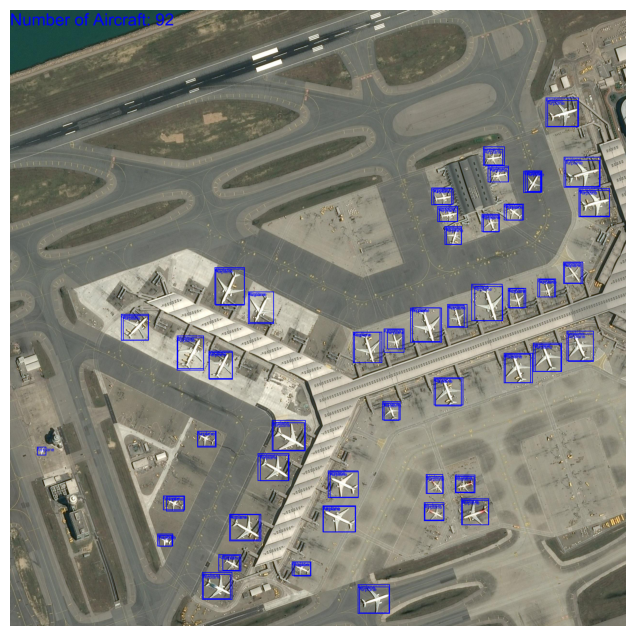

In [22]:
img_id = 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg'
plot_annot(final_df, img_id)

The image with the most number of aircraft has 2 sets of annotations over it, with a slight difference in coords. The drop_duplicates function in pandas will not be able to sort this out so the extra set of annotations will be manually sorted out and removed.

In [23]:
final_df[final_df['image_id'] == 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg'].head(46)

image_id     class  \
923   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
924   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
925   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
926   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
927   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
928   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
929   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
930   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
931   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
932   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
933   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
934   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
935   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
936   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
937   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
938   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
939   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
940   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
941   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
942   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
943   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
944   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
945   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
946   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
947   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
948   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
949   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
950   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
951   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
952   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
953   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
954   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
955   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
956   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
957   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
958   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
959   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
960   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
961   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
962   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
963   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
964   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
965   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
966   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
967   d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   
3294  d9399a45-6745-4e59-8903-90640b2ddf9f.jpg  Airplane   

                          bbox  width  height  
923     (2226, 364, 2363, 486)    137     122  
924     (2301, 610, 2453, 737)    152     127  
925     (2363, 741, 2492, 860)    129     119  
926     (1966, 567, 2055, 646)     89      79  
927     (1985, 647, 2072, 715)     87      68  
928     (2052, 805, 2135, 873)     83      68  
929     (1960, 847, 2034, 921)     74      74  
930     (1751, 738, 1836, 810)     85      72  
931     (1776, 815, 1860, 880)     84      65  
932     (1806, 898, 1877, 975)     71      77  
933   (2299, 1046, 2381, 1137)     82      91  
934   (2313, 1333, 2425, 1458)    112     125  
935   (2192, 1116, 2268, 1193)     76      77  
936   (2069, 1155, 2144, 1237)     75      82  
937   (2173, 1383, 2293, 1503)    120     120  
938   (2052, 1425, 2172, 1550)    120     125  
939   (1761, 1527, 1883, 1642)    122     115  
940   (1547, 1626, 1622, 1704)     75      78  
941   (1917, 1138, 2046, 1291)    129     153  
942   (1817, 1222, 1900, 1319)     83      97  
943   (1663, 1237, 1794, 1381)    131     144  
944   (1553, 1324, 1638, 1423)     85      99  
945   (1425, 1337, 1546, 1466)    121     129  
946     (850, 1069, 975, 1224)    125     155  
947    (989, 1170

The later indexed set has more annotations, containing the small aircraft to the left of the image above as well. The first indexed (923-967) set will hence be dropped. Using visual inspection, note that there is an aircraft on the upper right hand side of the image that has 3 bounding boxes around it. Correspondingly, there is another extra annotation at index 3340, which will also be dropped.

In [24]:
final_df.drop(range(923,968), inplace=True)
final_df.drop(3340, inplace=True)
final_df.reset_index(drop=True, inplace=True)

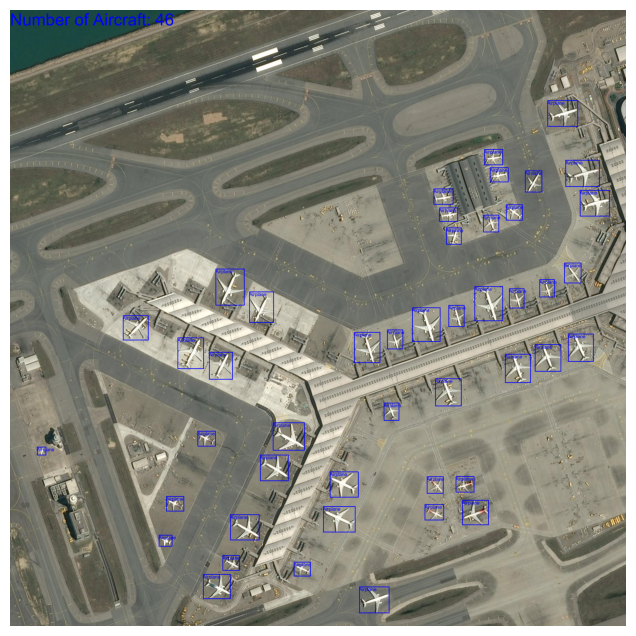

In [25]:
img_id = 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg'
plot_annot(final_df, img_id)

Cleaned :) the actual aircraft count is 46.

#### Image with Second Highest Aircraft Count (88)

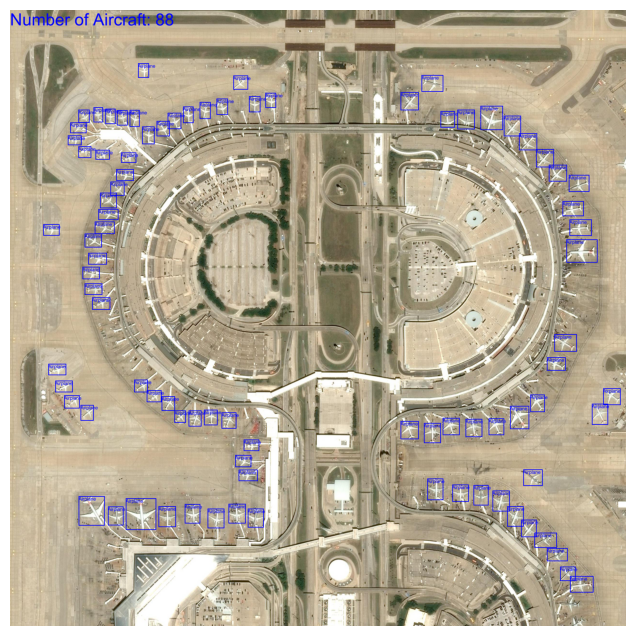

In [26]:
img_id = 'cbd51501-ed0f-411c-b472-df4357cca40c.jpg'
plot_annot(final_df, img_id)

Thankfully the image with the second most number of aircraft has does not have the same issue.

### Distribution of Bounding Box Sizes

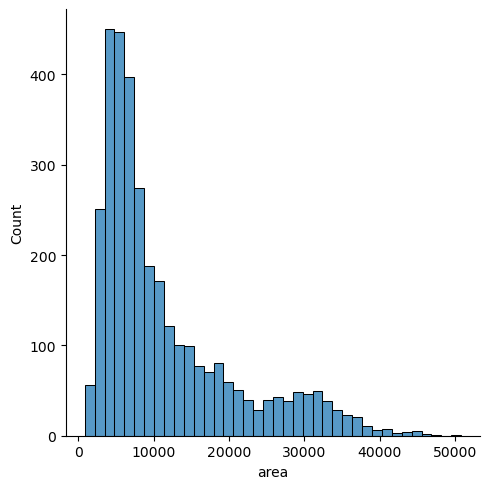

In [27]:
final_df['area'] = final_df['width'] * final_df['height']
sns.displot(final_df['area'])

#### Investigate bounding boxes >50,000 pixels.

In [28]:
final_df[final_df['area']>=50000]

image_id     class  \
75  72fa2a77-cf8e-44a2-9ab2-f11ca63b4b72.jpg  Airplane   

                      bbox  width  height   area  
75  (1855, 630, 2076, 860)    221     230  50830

In [29]:
final_df.iloc[75]

image_id    72fa2a77-cf8e-44a2-9ab2-f11ca63b4b72.jpg
class                                       Airplane
bbox                          (1855, 630, 2076, 860)
width                                            221
height                                           230
area                                           50830
Name: 75, dtype: object

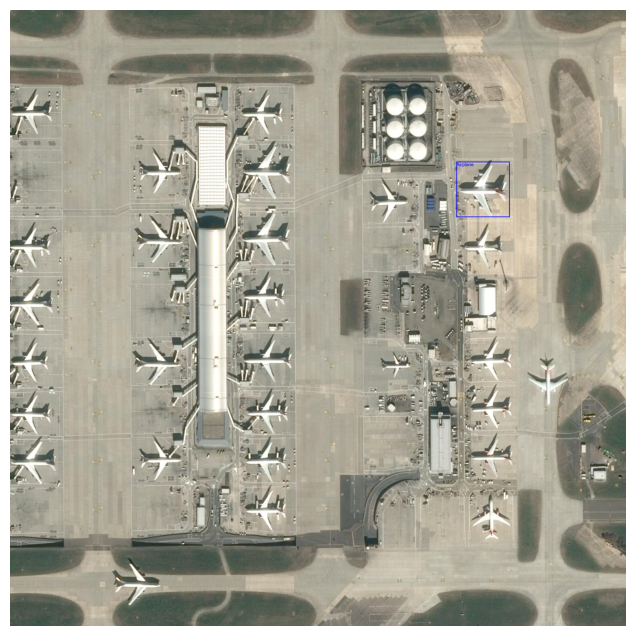

In [31]:
img_path = os.path.join('data','images','72fa2a77-cf8e-44a2-9ab2-f11ca63b4b72.jpg')
image = Image.open(img_path)

font_path = "C:\Windows\Fonts\Arial.ttf" # None bitmap font so that the font size can be controlled.
font = ImageFont.truetype(font_path, size=20)

plotted_image = ImageDraw.Draw(image)

row = final_df.iloc[75]
plotted_image.rectangle(row['bbox'], width=3, outline=(0,0,255))
plotted_image.text((row['bbox'][0], row['bbox'][1]), final_df.loc[75,'class'], font=font, fill=(0,0,255))

plt.figure(figsize=(8,8), frameon=False)
plt.axis('off')
plt.imshow(image)

Nothing too suspicious here, just a jumbo A380 taken from a slightly more zoomed in perspective.

## Post-clean
Final descriptive numbers after checking out the images and annotation that stood out.

In [32]:
unique, counts = np.unique(final_df['image_id'], return_counts=True)
#per_image = np.asarray((unique, counts)).T
print(f'Fewest aircraft in an image: {min(counts)}')
print(f'Most aircraft in an image: {max(counts)}')
print(f'Mean number of aircrafts per image: {int(np.mean(counts))}')
print(f'Total number of aircraft: {sum(counts)}')
print(f'Number of images: {len(imgs)}')

Fewest aircraft in an image: 5
Most aircraft in an image: 88
Mean number of aircrafts per image: 32
Total number of aircraft: 3379
Number of images: 103


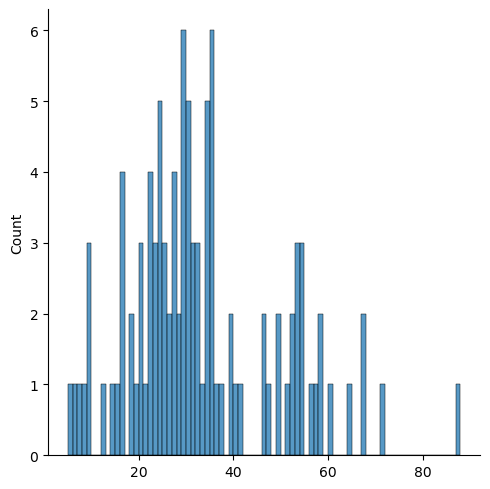

In [33]:
sns.displot(counts, binwidth=1)

As the images are taken over commercial airports, the size of the aircraft and hence the size of the bounding boxes are largely within the same range (subject to perspective and truncation). As seen from the sample image with annotations earlier, there is indeed relatively fewer smaller aircraft types, with the majority of the aircraft being commercial jets (mostly Medium to Heavy aircraft categories), with the occasional quad engine jet, likely accounting for the bump in number of larger bounding boxes around 30,000pixels

The total number of aircraft labelled in the final dataset stands at 3379 across 109 satellite images.
- The number of aircraft in an image range from 5 to 88, with a mean of 32 aircraft per image. 

In [34]:
final_df.to_csv('data/dataset.csv', index=False)

---
## End of Pt1
That concludes the exploration of the dataset, part2 notebook for image preprocessing

---